# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

## Описание и цели проекта

Заказчик этого исследования — сеть отелей «Как в гостях».

Чтобы привлечь клиентов, эта сеть добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня.

Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.

Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

**ОПИСАНИЕ ДАННЫХ**

В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:
- `id` — номер записи;
- `adults` — количество взрослых постояльцев;
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `babies` — количество младенцев;
- `booking_changes` — количество изменений параметров заказа;
- `children` — количество детей от 3 до 14 лет;
- `country` — гражданство постояльца;
- `customer_type` — тип заказчика:
  - `Contract` — договор с юридическим лицом;
  - `Group` — групповой заезд;
  - `Transient` — не связано с договором или групповым заездом;
  - `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `distribution_channel` — канал дистрибуции заказа;
- `is_canceled` — отмена заказа;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `meal` — опции заказа:
  - `SC` — нет дополнительных опций;
  - `BB` — включён завтрак;
  - `HB` — включён завтрак и обед;
  - `FB` — включён завтрак, обед и ужин.
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type` — тип забронированной комнаты;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей;
- 
`total_of_special_requests` — количество специальных отметок.

In [1]:
# Проинсталируем ydata-profiling
!pip install pandas_profiling[notebook]

In [2]:
!pip install scikit-learn==1.1.3

## Шаг 1. Откройте файлы с данными

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pandas_profiling
from termcolor import colored
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

/tmp/ipykernel_301/2813956462.py:5: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [4]:
try:
    df_train = pd.read_csv('/datasets/hotel_train.csv')
    df_test = pd.read_csv('/datasets/hotel_test.csv')
except:
    df_train = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_train.csv')
    df_test = pd.read_csv('https://code.s3.yandex.net/datasets/hotel_test.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

In [5]:
df_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.00,2015,July,27,1,0,1,1.00,0.00,0.00,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.00,2015,July,27,1,0,2,2.00,0.00,0.00,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.00,2015,July,27,1,0,2,2.00,0.00,0.00,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.00,2015,July,27,1,0,2,2.00,0.00,0.00,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.00,2015,July,27,1,0,3,2.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [7]:
df_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.00,2017,January,1,1,1,0,2.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.00,2017,January,1,1,2,2,2.00,0.00,0.00,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.00,2017,January,1,1,2,2,2.00,0.00,0.00,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.00,2017,January,1,1,2,2,1.00,0.00,0.00,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.00,2017,January,1,1,2,5,2.00,0.00,0.00,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

### Вывод:
- Представлены два датасета, один для обучения модели, другой - для тестирования. Данные для обучения и тестирования соотносятся, примерно, как 2:1.
- Данные содержат **25 признаков**, в том исле: 11 категориальных и 14 числовых

## Шаг 2. Предобработка и исследовательский анализ данных

In [ ]:
# Поскольку данных много, воспользуемся быстрым анализом данных из pandas_profiling
pandas_profiling.ProfileReport(df_train)

In [ ]:
pandas_profiling.ProfileReport(df_test)

In [11]:
# Дополнительно проверим на дубликаты по ID
df_train.id.duplicated().sum()

0

In [12]:
# Посмотрим с какого периода начинаются данные в обучающем датасете
df_train.query('arrival_date_year == 2015').arrival_date_month.value_counts()

September    4443
October      4284
August       3116
December     2370
July         2185
November     1930
Name: arrival_date_month, dtype: int64

In [13]:
# Уберем лишние пробелы в названиях признаков типа object
df_train[df_train.select_dtypes(include=['object']).columns] = \
df_train[df_train.select_dtypes(include=['object']).columns].apply(lambda x: x.str.strip())

df_test[df_test.select_dtypes(include=['object']).columns] = \
df_test[df_test.select_dtypes(include=['object']).columns].apply(lambda x: x.str.strip())

In [14]:
#Сделаем копии датасетов для дальнейшей работы и сделаем замер датасетов до преобразований
df_train_new = df_train
df_test_new = df_test

df_train_new.shape, df_test_new.shape

((65229, 25), (32412, 25))

In [15]:
# Удалим столбцы с лишней информацией: id, arrival_date_year, arrival_date_week_number, total_nights 
df_train_new.drop(['id','arrival_date_year', 'arrival_date_week_number', 'total_nights',
                   'is_repeated_guest'], axis=1, inplace=True)
df_test_new.drop(['id','arrival_date_year', 'arrival_date_week_number', 'total_nights', 
                  'is_repeated_guest'], axis=1, inplace=True)

In [16]:
# Изменим типы данных float на int в обоих датасетах
df_train_new = df_train_new.astype({ 
    'lead_time': 'int',
    'adults': 'int',
    'children': 'int',
    'babies': 'int'
})

df_test_new = df_test_new.astype({ 
    'lead_time': 'int',
    'adults': 'int',
    'children': 'int',
    'babies': 'int'
})

# Проверим изменения
print(df_train_new.dtypes, '\n', '--------------------------------------',
      '\n', df_test_new.dtypes)

is_canceled                        int64
lead_time                          int64
arrival_date_month                object
arrival_date_day_of_month          int64
stays_in_weekend_nights            int64
stays_in_week_nights               int64
adults                             int64
children                           int64
babies                             int64
meal                              object
country                           object
distribution_channel              object
previous_cancellations             int64
previous_bookings_not_canceled     int64
reserved_room_type                object
booking_changes                    int64
days_in_waiting_list               int64
customer_type                     object
required_car_parking_spaces        int64
total_of_special_requests          int64
dtype: object 
 -------------------------------------- 
 is_canceled                        int64
lead_time                          int64
arrival_date_month                object


In [17]:
#Удалим аномальные значения по столбцу babies и adults
df_train_new = df_train_new[(df_train_new['babies'] < 2) & (df_train_new['adults'] != 0)]\
.rename(columns={'babies':'has_babies'})

df_test_new = df_test_new[(df_test_new['babies'] < 2) & (df_test_new['adults'] != 0)]\
.rename(columns={'babies':'has_babies'})


Визуализируем некоторые категориальные признаки. Построим барплот и посмотрим на долю отмен по каждой категории признака

In [18]:
# Создаим словарь с датасетами
df_group = {'df_train': df_train,'df_test': df_test}
# Создадим список признаков для исследоания
col_list = ['arrival_date_month', 'adults', 'children', 'reserved_room_type', \
            'customer_type', 'required_car_parking_spaces']

------------------------------Графики для df_train------------------------------
--------------------------------------------------------------------------------


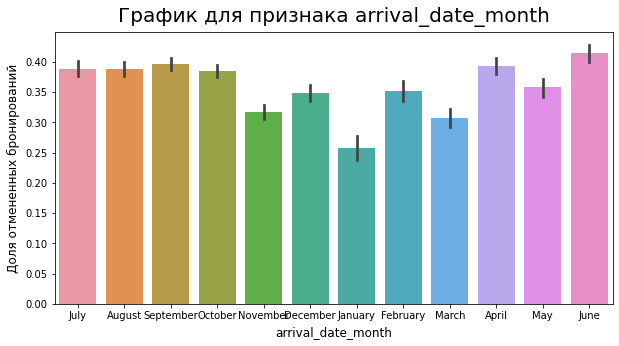

--------------------------------------------------------------------------------


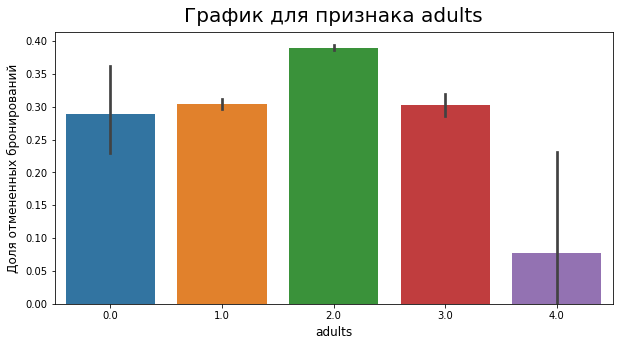

--------------------------------------------------------------------------------


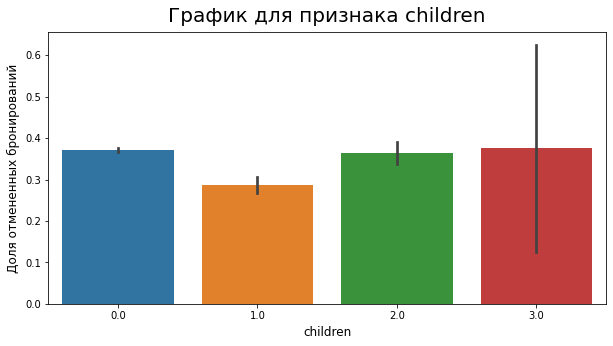

--------------------------------------------------------------------------------


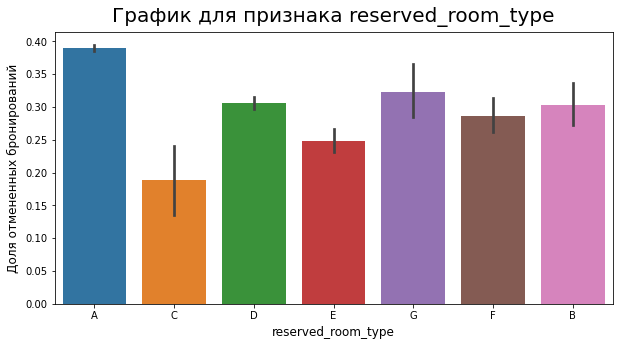

--------------------------------------------------------------------------------


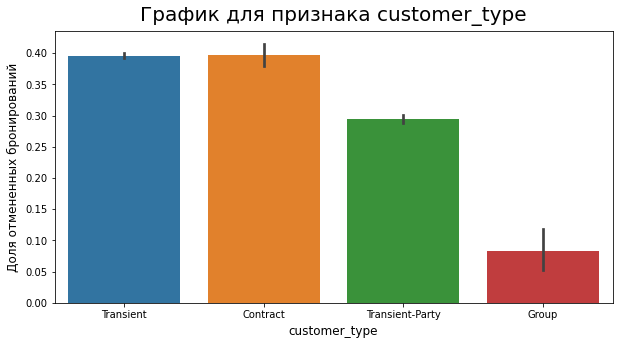

--------------------------------------------------------------------------------


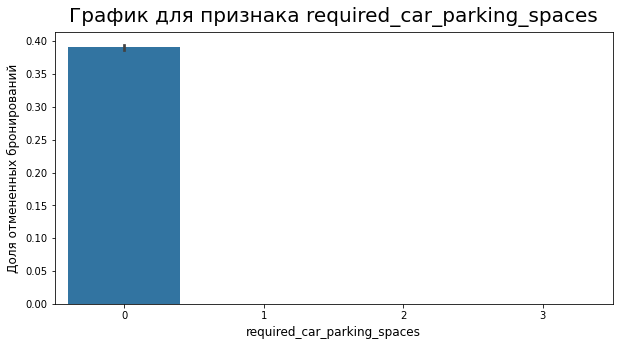

------------------------------Графики для df_test-------------------------------
--------------------------------------------------------------------------------


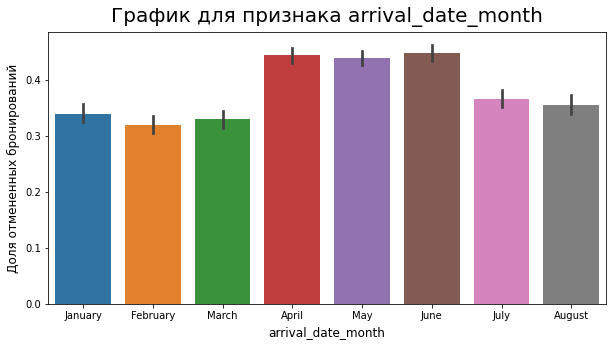

--------------------------------------------------------------------------------


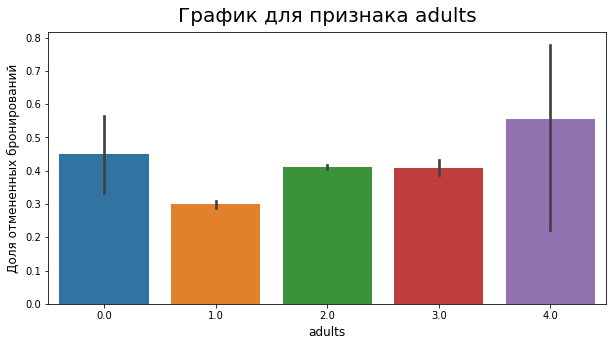

--------------------------------------------------------------------------------


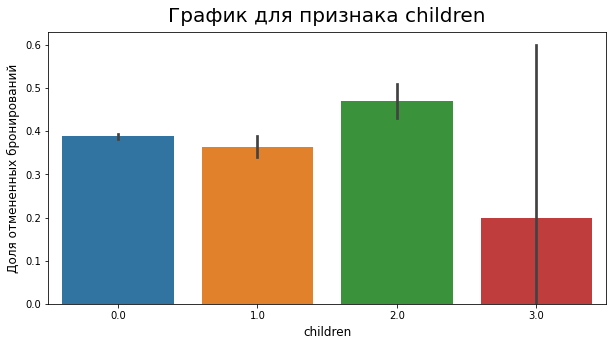

--------------------------------------------------------------------------------


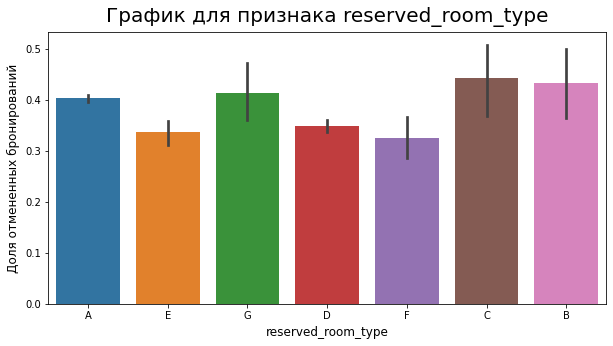

--------------------------------------------------------------------------------


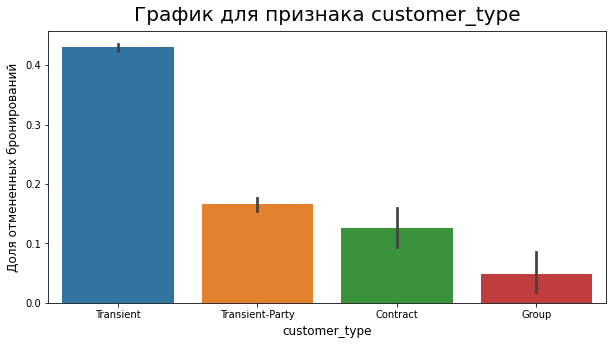

--------------------------------------------------------------------------------


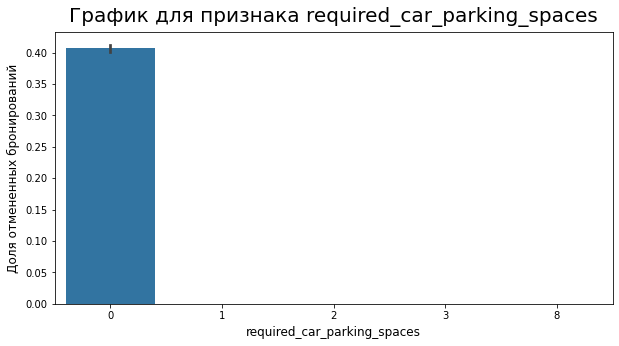

In [19]:
# Создадим цикл для построения графиков 
for name,i in df_group.items():
    text = "Графики для " + name
    print(colored(text.center(80, '-'), attrs=['bold'],)) 
    for col in col_list:
        plt.figure(figsize=(10,5)) 
        plt.title("График для признака " + col, fontsize = 20, pad = 10)
        sns.barplot(data=i, x=col, y='is_canceled')
        plt.xlabel(col, fontsize = 12, labelpad = 5)
        plt.ylabel("Доля отмененных бронирований", fontsize = 12, labelpad = 5);
        print('--------------------------------------------------------------------------------')

        plt.show() 

Как видно из графиков, доля отмен по месяцам разнятся у датасетов, это связано с разным временным периодом исследуемых данных. Но в обоих случаях видно, что большая часть отмен приходится на высокий сезон.

По количеству взрослых лидером по отменам брони в тренировочном датасете является номер на двоих.

Также видно, что больше отмен при бронировании когда нет детей, здесь самый маленький доверительный интервал.

Самая популярная категория номера при отмене - "А"

Отменяют бронь клиенты без автомобилей и не связанные с групповым бронированием

Теперь визуализируем некоторые численные признаки в обоих датасетах. Построим для каждого из них график распределения и диаграмму размаха

In [20]:
# Создаим словарь с датасетами
df_group = {'df_train': df_train,'df_test': df_test}
# Создадим список признаков для исследоания
column_list = ['lead_time', 'previous_cancellations', 'previous_bookings_not_canceled', \
               'booking_changes', 'days_in_waiting_list']

------------------------------Графики для df_train------------------------------
--------------------------------------------------------------------------------


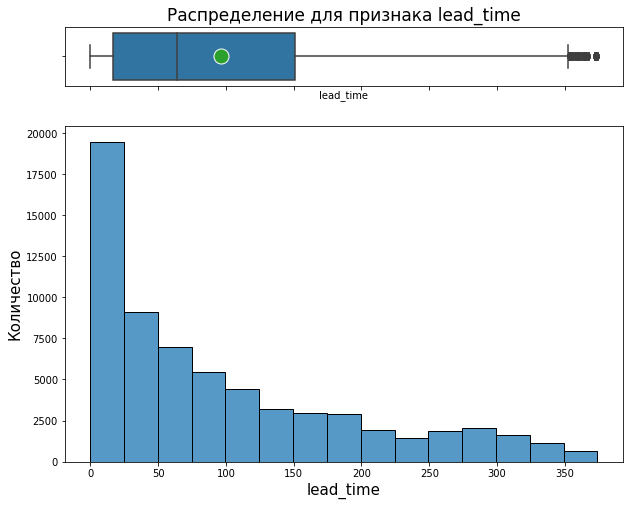

--------------------------------------------------------------------------------


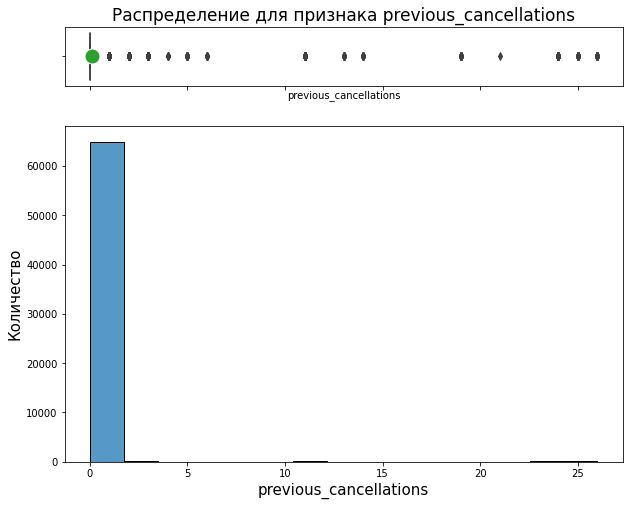

--------------------------------------------------------------------------------


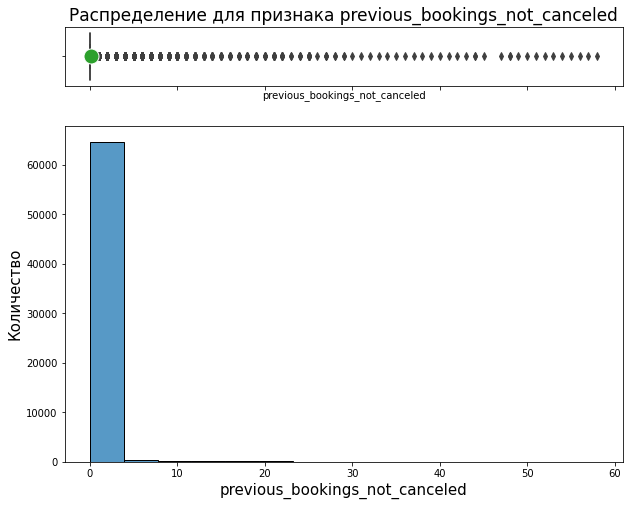

--------------------------------------------------------------------------------


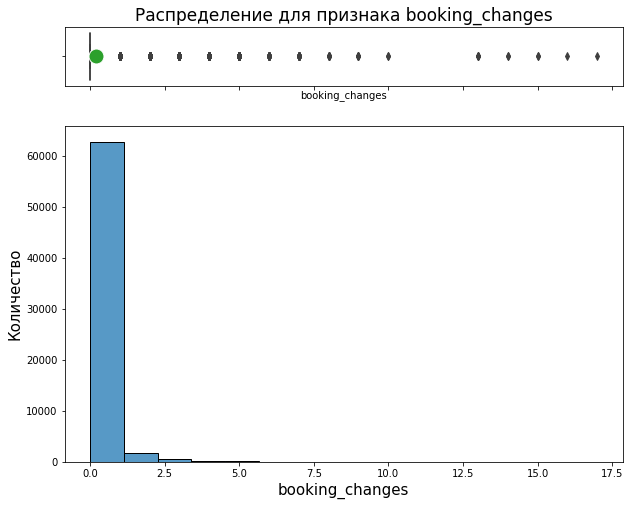

--------------------------------------------------------------------------------


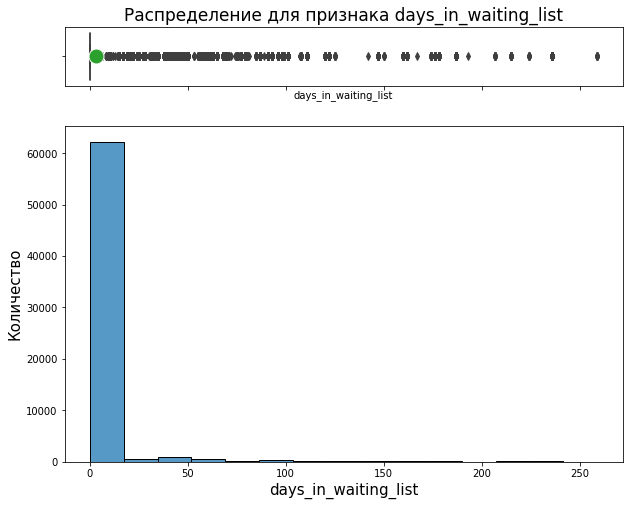

------------------------------Графики для df_test-------------------------------
--------------------------------------------------------------------------------


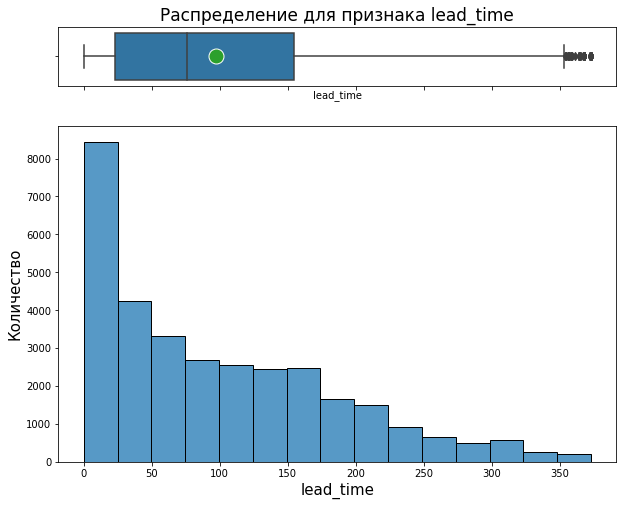

--------------------------------------------------------------------------------


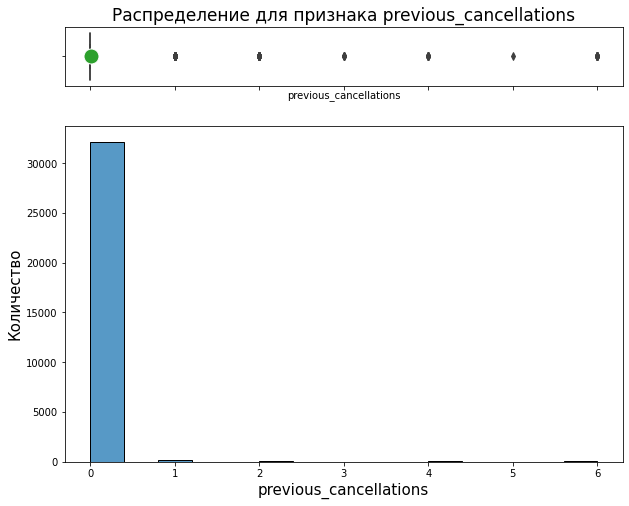

--------------------------------------------------------------------------------


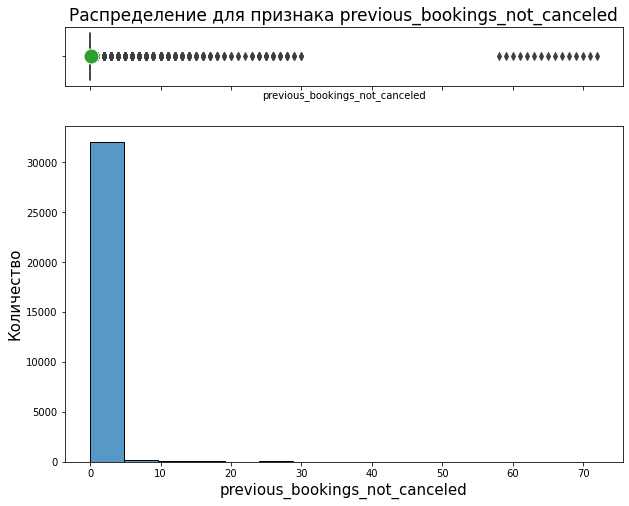

--------------------------------------------------------------------------------


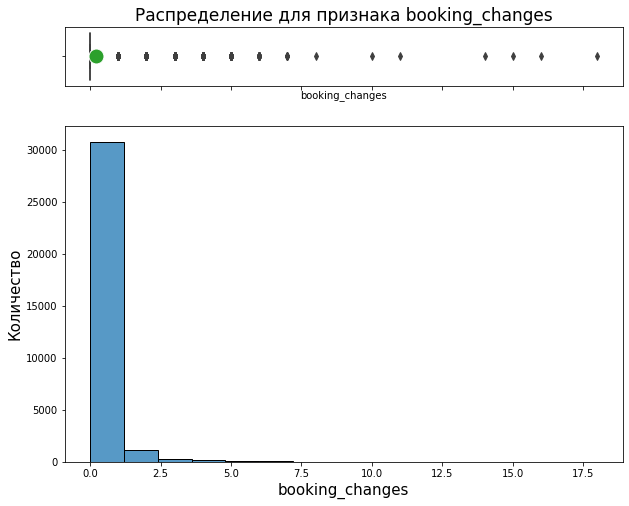

--------------------------------------------------------------------------------


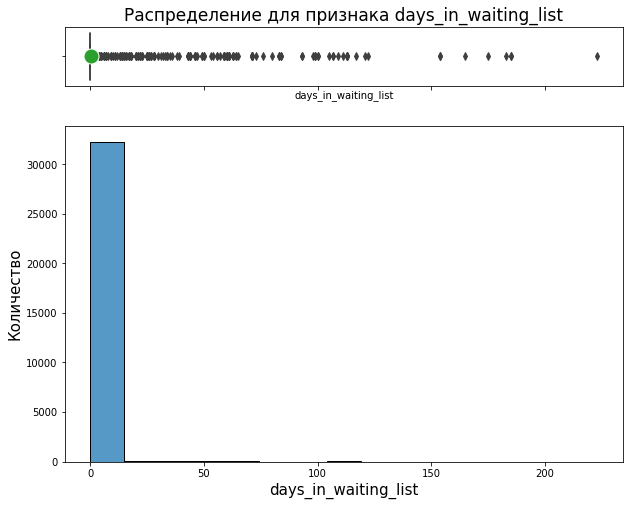

In [21]:
# Создадим цикл для построения диаграмм размаха и графиков распределения 
for name,i in df_group.items():
    text = "Графики для " + name
    print(colored(text.center(80, '-'), attrs=['bold'],)) 
    for col in column_list:
        # Создадим два подграфика
        f, (ax_box, ax_hist) = \
        plt.subplots(nrows = 2, # из двух строк
        ncols = 1, # и одного столбца
        sharex = True, # оставим только нижние подписи к оси Х
        gridspec_kw = {'height_ratios': (.15, .85)}, # зададим разную высоту строк
        figsize = (10,8)) # зададим размер графика
        
        # в первом подграфике построим boxplot
        sns.boxplot(x = i[col],
            ax = ax_box,
            showmeans=True, # покажем среднее значение
            meanprops={"marker": "o",
                       "markeredgecolor": "white",
                       "markersize": "15"})
        # во втором гистограмму
        sns.histplot(data = i[col], bins = 15, ax = ax_hist)

        # зададим заголовок и подписи к осям
        ax_box.set_title('Распределение для признака ' + col, fontsize = 17)
        ax_hist.set_xlabel(col, fontsize = 15)
        ax_hist.set_ylabel('Количество', fontsize = 15)
        print('--------------------------------------------------------------------------------')

        plt.show() 
    

На графиках видно, что исследуемые признаки имеют выбросы. Их достатлчно много, поэтому удалять не будем, а обрежем по верхней границе. Определим границы для каждого признака отдельно. Критерием для определения будет доля отмен бронирования, которая приходится на эту часть данных

In [22]:
# Посмотрим какой процент отмен приходится на изменения в бронировании больше 3 
total_canceled = len(df_train_new[df_train_new['is_canceled']==1])

df_train_new.query('booking_changes >= 3 & is_canceled == 1').is_canceled.count()\
/ total_canceled * 100

0.48758126354392395

In [23]:
# Присвоим значение 3 тем показателям, которые его превышают
df_train_new.loc[df_train_new['booking_changes'] > 3, 'booking_changes'] = 3

In [24]:
# Посмотрим какой процент отмен приходится на заказы с подтверждением более 100 дней
df_train_new.query('days_in_waiting_list >= 100 & is_canceled == 1').is_canceled.count()\
/ total_canceled *100

1.1710285047507918

In [25]:
# Присвоим значение 100 тем показателям, которые его превышают
df_train_new.loc[df_train_new['days_in_waiting_list'] > 100, 'days_in_waiting_list'] = 100

In [26]:
# Посмотрим какой процент отмен приходится на клиентов с двумя и более подтверденными заказами
df_train_new.query('previous_bookings_not_canceled >= 2 & is_canceled == 1').is_canceled.count()\
/ total_canceled *100

0.26254375729288215

In [27]:
# Присвоим значение 2 тем показателям, которые его превышают
df_train_new.loc[df_train_new['previous_bookings_not_canceled'] > 2, \
                 'previous_bookings_not_canceled'] = 2

In [28]:
# Посмотрим какой процент отмен приходится на клиентов с двумя и более отменными заказами
df_train_new.query('previous_cancellations >= 2 & is_canceled == 1').is_canceled.count()\
/ total_canceled *100

0.6834472412068678

In [29]:
# Присвоим значение 2 тем показателям, которые его превышают
df_train_new.loc[df_train_new['previous_cancellations'] > 2, 'previous_cancellations'] = 2

In [30]:
# Объединим часть стран, которые редко встречаются,  в новую категорию
# для этого создадим фрейм с такими странами
country_train = pd.DataFrame(df_train_new.country.value_counts()).query('country <= 500').index

country_test = pd.DataFrame(df_test_new.country.value_counts()).query('country <= 500').index


In [31]:
# Посмотрим какой процент отмен приходится на редкие страны
df_train_new[(df_train_new['country'].isin(country_train)) & (df_train_new['is_canceled'] == 1)].is_canceled.count()\
/total_canceled *100

5.280046674445741

In [32]:
# Заменим редкие страны на категорию 'etc'
def coun(row): 
    if row in country_train or row in country_test:
        return 'etc'
    return row
df_train_new.country = df_train_new.country.apply(coun)
df_test_new.country = df_test_new.country.apply(coun)

In [33]:
df_test_new.country.value_counts()

PRT    9877
etc    4724
GBR    3924
FRA    3468
DEU    2374
ESP    1930
ITA    1152
IRL    1059
BEL     880
BRA     876
USA     769
NLD     707
CHE     599
Name: country, dtype: int64

In [34]:
# Посмотрим размер датасетов после преобразований и изменений 
df_train_new.shape, df_test_new.shape

((65058, 20), (32339, 20))

### Вывод:
Итоги исследования и предобработки данных:
- Нам предлагается обучить модель на данных **2015(второе полугодие)-2016 года** (около 65 тыс.записей о брогировании) и провести тестирование на данных за **9 месяцев 2017 года** (около 32 тыс. записей о бронировании)
- Данные не слишком дисбаллансированы. В обучающем сете 37% записей имеют статус отказа от бронирования, в тестовом  - около 39% таких записей. В обоих случаях - **доля отказов от общего количества забронированых номеров достаточно большая**.
- Целевой признак **is_canceled** заметной корреляции с другими признаками не имеет
- Данные в обоих датасетах **не содержат пропусков**
- Данные в обоих датасетах **не содержат дубликатов**
- Имеются 4 признака типа **float**, которые мы преобразовали в целочисленные. Также есть 6 признаков с типом **object**, которые в дальнейшем будем кодировать и переводить в числа
- Мы почистили данные с признаком *object* от лишних пробелов
- Поскольку временные границы в обучающем и тестовом сетах разные, значит есть **различия в распределении данных по месяцам**.
- Есть два аномальных значения в обучающем сете по признаку *babies*, мы их удалили.
- Есть выбросы в признаках **booking_changes, days_in_waiting_list,  previous_cancellations, previous_bookings_not_canceled**. Здесь мы не удалили, а обрезали данные по верхней границе, которую определили для каждого случая отдельно. Основным критерием было, чтобы на обрезанную часть не приходилась какая-то значимая часть отмен бронирования. Данные изменения мы делали только в обучающем датасете
- Для построения более качественной модели мы удалили некоторые признаки, которые не оказывают влияние на целевой признак, либо дублируют уже имеющиеся признаки. Всего было удалено 5 столбцов:  **id, arrival_date_year, arrival_date_week_number, total_night, is_repeated_guest **
- Признак с названием страны **country** имеет очень много уникальных значений, для сокращения этого количества, мы объединили часть стран с наименьшим числом повторений в отдельную категорию. На все объединенные страны приходится около 5% отмен бронирования. 

## Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Посчитаем какую прибыль получила компания в 2017 году по имеющимся данным, чтоб в дальнейшем сравнить ее с результатами, которые получатся после внедрении модели.

In [35]:
# Сохраним данные для расчетов в отдельые переменные
BUDGET = 400_000 # Бюджет на внедрении

In [36]:
# Создадим датафрейм с тарифами за проживание и румсервис
night_rate = pd.DataFrame({'reserved_room_type': ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
                           'price_per_night': [1000, 800, 600, 550, 500, 450, 350],
                           'room_service': [400, 350, 350, 150, 150, 150, 150]})
night_rate

,reserved_room_type,price_per_night,room_service
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


In [37]:
# Создадим датафрейм с сезонными коэффициентами
# к1 будет использоваться в расчетах когда все ночи попадают в один сезон
# к2 - для расчетов когда заезд и выезд из отеля приходится на разные сезоны
# days - количество дней в месяце
season_rate = pd.DataFrame({'arrival_date_month': ['January', 'February', 'March',
                                    'April', 'May', 'June', 'July', 'August', 'September'], 
                            'k1': [1.0, 1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2],
                            'k2': [1.0, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4, 1.2, 1.2],
                            'days': [31, 28, 31, 30, 31, 30, 31, 31, 30]})
season_rate

,arrival_date_month,k1,k2,days
0,January,1.00,1.00,31
1,February,1.00,1.20,28
2,March,1.20,1.20,31
3,April,1.20,1.20,30
4,May,1.20,1.40,31
5,June,1.40,1.40,30
6,July,1.40,1.40,31
7,August,1.40,1.20,31
8,September,1.20,1.20,30


In [38]:
# Теперь создадим датасет для расчета прибыли(выручки) отеля
# для этого соединим новые датафреймы и наш исследуемый 
# также добавим столбец predictions, в который потом вставим предсказания модели,
# пока все значения в этом столбце будут равны 0

df_test_profit = df_test_new.merge(night_rate, how='left', on='reserved_room_type')

df_test_profit = df_test_profit.merge(season_rate, how='left', on='arrival_date_month')

df_test_profit['predictions'] = 0

df_test_profit

,is_canceled,lead_time,arrival_date_month,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,meal,country,distribution_channel,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,price_per_night,room_service,k1,k2,days,predictions
0,1,74,January,1,1,0,2,0,0,BB,PRT,TA/TO,0,0,A,0,0,Transient,0,0,1000,400,1.00,1.00,31,0
1,1,62,January,1,2,2,2,0,0,BB,etc,TA/TO,0,0,A,0,0,Transient,0,1,1000,400,1.00,1.00,31,0
2,1,62,January,1,2,2,2,0,0,BB,etc,TA/TO,0,0,A,0,0,Transient,0,1,1000,400,1.00,1.00,31,0
3,1,71,January,1,2,2,1,0,0,BB,PRT,TA/TO,0,0,A,0,0,Transient,0,1,1000,400,1.00,1.00,31,0
4,1,172,January,1,2,5,2,0,0,BB,BEL,TA/TO,0,0,A,0,0,Transient,0,0,1000,400,1.00,1.00,31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32334,0,164,August,31,2,4,2,0,0,BB,DEU,TA/TO,0,0,A,0,0,Transient,0,0,1000,400,1.40,1.20,31,0
32335,0,21,August,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,A,0,0,Transient,0,2,1000,400,1.40,1.20,31,0
32336,0,23,August,30,2,5,2,0,0,BB,BEL,TA/TO,0,0,A,0,0,Transient,0,0,1000,400,1.40,1.20,31,0
32337,0,34,August,31,2,5,2,0,0,BB,DEU,TA/TO,0,0,D,0,0,Transient,0,4,550,150,1.40,1.20,31,0


In [39]:
#Напишем функцию для расчета прибыли(выручки)
def revenue(row):
    
    # Сумма депозита, если модель покажет, что бронь будет отменена
    deposit = (row['price_per_night'] * row['k1'] + row['room_service']) * 0.8
    
    # Общее количество ночей
    total_night = row['stays_in_weekend_nights'] + row['stays_in_week_nights']
    
    # Количество дней до конца месяца
    days_to_end_month = row['days'] - row['arrival_date_day_of_month'] + 1
    
    # Сумма за обслуживание номера
    roomservice = row['room_service'] + \
    (row['room_service'] * math.ceil(total_night / 2 - 1)) * (1 - row['is_canceled'])
    
    if total_night <= days_to_end_month:
        total_profit = total_night * row['price_per_night'] * row['k1'] *\
        (1 - row['is_canceled']) - row['is_canceled'] * (row['price_per_night'] * row['k1']-\
        deposit * row['predictions']) - roomservice
        return total_profit
    else:
        total_profit = (row['price_per_night'] * (days_to_end_month * row['k1'] +\
                (total_night - days_to_end_month) * row['k2']) * (1 - row['is_canceled'])) -\
                roomservice - row['is_canceled'] *\
                (row['price_per_night'] * row['k1'] - deposit * row['predictions'])
        return total_profit
       

In [40]:
# Посчитаем прибыль отеля за 2017 год до внедрения модели
total_revenue = df_test_profit.apply(revenue, axis=1).sum() / 1e6
print('Прибыль отеля за 2017г до внедрения модели:', total_revenue.round(2), 'млн.руб')
print('Ожидаемая прибыль отеля после внедрения модели, не менее:',
      (total_revenue + BUDGET / 1e6).round(2), 'млн.руб')

Прибыль отеля за 2017г до внедрения модели: 35.26 млн.руб
Ожидаемая прибыль отеля после внедрения модели, не менее: 35.66 млн.руб


### Вывод:
- Прибыль отеля за 2017г (тестируемый период) до внедрения модели составила 35,26 млн.руб. По условию задания, прибыль после внедрения модели должна быть выше затарат на ее внедрение. Значит ожидаемая прибыль должна быть не менее 35,66 млн.руб.
- ML-задача данного проекта - построить модель, которая будет определять вероятность отмены бронирования и предлагать внести депозит. Это позволит избежать убытков, которые терпела компания при отмене бронирования, а значит, увеличить прибыль.

## Шаг 4. Разработка модели ML

In [41]:
# Выделим признаки в обучающем и тестовом датасетах
features_train = df_train_new.drop('is_canceled', axis = 1)
target_train = df_train_new['is_canceled']


features_test = df_test_new.drop('is_canceled', axis = 1)
target_test = df_test_new['is_canceled']

In [42]:
# Обозначим категориальные признаки для ОНЕ
ohe_features = features_train.select_dtypes(include='object').columns.to_list()
ohe_features

['arrival_date_month',
 'meal',
 'country',
 'distribution_channel',
 'reserved_room_type',
 'customer_type']

In [43]:
# Обозначим численные признаки 
num_features = features_train.select_dtypes(include='int').columns.to_list()
num_features

['lead_time',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'has_babies',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [44]:
# Закодируем категориальные и стандартизируем численные признаки
# drop='first' удаляет первый признак из закодированных:
# таким образом обходим dummy-ловушку
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

# обучаем энкодер на заданных категориальных признаках тренировочного датасета
encoder_ohe.fit(features_train[ohe_features])

# добавляем закодированные признаки в features_train
# encoder_ohe.get_feature_names_out() позволяет получить названия колонок
features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[ohe_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train = features_train.drop(ohe_features, axis=1)

# создаём скелер
scaler = StandardScaler()

# обучаем его на численных признаках тренировочного датасета, трансформируем его же
features_train[num_features] = scaler.fit_transform(features_train[num_features])

# смотрим на результат
features_train.head()

,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_BRA,country_CHE,country_DEU,country_ESP,country_FRA,country_GBR,country_IRL,country_ITA,country_NLD,country_PRT,country_USA,country_etc,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.93,-1.70,-0.97,-0.90,-1.78,-0.22,-0.08,-0.30,-0.15,-0.36,-0.20,-0.24,-0.68,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,-0.86,-1.70,-0.97,-0.17,0.34,-0.22,-0.08,-0.30,-0.15,-0.36,-0.20,-0.24,0.65,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,-1.00,-1.70,-0.97,-0.17,0.34,-0.22,-0.08,-0.30,-0.15,-0.36,-0.20,-0.24,-0.68,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,-0.91,-1.70,-0.97,-0.17,0.34,-0.22,-0.08,-0.30,-0.15,-0.36,-0.20,-0.24,0.65,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,-0.12,-1.70,-0.97,0.57,0.34,-0.22,-0.08,-0.30,-0.15,-0.36,-0.20,-0.24,0.65,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


In [45]:
# энкодером, который обучен на ТРЕНИРОВОЧНОМ датасете, кодируем тестовый
features_test[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_test[ohe_features])

features_test = features_test.drop(ohe_features, axis=1)

# скелером, который обучен на ТРЕНИРОВОЧНОМ датасете, масштабируем тестовый
features_test[num_features] = scaler.transform(
    features_test[num_features]
)

# смотрим на результат
features_test.head()

,lead_time,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,has_babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_FB,meal_HB,meal_SC,country_BRA,country_CHE,country_DEU,country_ESP,country_FRA,country_GBR,country_IRL,country_ITA,country_NLD,country_PRT,country_USA,country_etc,distribution_channel_Direct,distribution_channel_GDS,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.23,-1.70,0.21,-1.64,0.34,-0.22,-0.08,-0.30,-0.15,-0.36,-0.20,-0.24,-0.68,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
1,-0.36,-1.70,1.38,-0.17,0.34,-0.22,-0.08,-0.30,-0.15,-0.36,-0.20,-0.24,0.65,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
2,-0.36,-1.70,1.38,-0.17,0.34,-0.22,-0.08,-0.30,-0.15,-0.36,-0.20,-0.24,0.65,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,-0.26,-1.70,1.38,-0.17,-1.78,-0.22,-0.08,-0.30,-0.15,-0.36,-0.20,-0.24,0.65,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.79,-1.70,1.38,2.05,0.34,-0.22,-0.08,-0.30,-0.15,-0.36,-0.20,-0.24,-0.68,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00


Признаки подготовлены, теперь построим модели. Проверим три модели для задачи классификации: решающего дерева, случайного леса и логистической регрессии. Оценим их качество кросс-валидацией
Поскольку дисбаланс классов есть, хоть и не слишком большой, применим в моделях параметр *class_weight='balanced'*. 

По отдельности полнота и точность не слишком информативны. Высокий показатель *Recall* может привести к обратному эффекту - прибыль отеля может уменьшиться из-за клиентов, которые передумали бронировать при условии внесения депозита. Высокий показатель *Precision* может не дать нужного количества депозитов, для покрытия расходов. Поэтому для оценки качества модели, в данном случае, лучше выбрать метрику *F1*, для того чтобы учитывать одновременно и точность и полноту.

In [46]:
# Построим и обучим модель решающего дерева
# Подберем лучшие параметры max_depth, min_samples_split, min_samples_leaf в цикле

best_f1_dtc = 0

for depth in range(1,10,1):
    for split in range(2,10,2):
        for leaf in range(2,10,2):
            model_dtc = DecisionTreeClassifier(max_depth=depth,
                                               min_samples_split=split,
                                               min_samples_leaf=leaf,
                                               class_weight='balanced',
                                               random_state=12345)
            scores = cross_val_score(model_dtc,features_train, target_train, cv=5, scoring='f1')
            final_score = sum(scores)/len(scores)
            if final_score > best_f1_dtc:
                params_dtc = model_dtc.get_params()
                best_f1_dtc = final_score                    
print('Лучшая средняя оценка f1 качества модели DTC:', best_f1_dtc, 'при параметрах:')
print(params_dtc)

Лучшая средняя оценка f1 качества модели DTC: 0.6899500682906495 при параметрах:
{'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 12345, 'splitter': 'best'}


In [47]:
# Построим и обучим модель случайного леса
# Подберем лучшие параметры в цикле

bootstrap = [True, False]
criterion = ['gini','entropy']

best_f1_rfc = 0

for est in range(1,10,1):
    for depth in range(1,10,1):
        for crit in criterion:
            for boot in bootstrap:
                model_rfc = RandomForestClassifier(max_depth=depth,
                                                   class_weight='balanced',
                                                   n_estimators=est,
                                                   criterion=crit,
                                                   bootstrap=boot,
                                                   random_state=12345)
                scores = cross_val_score(model_rfc, features_train, target_train, cv = 5,
                                         scoring = 'f1')
                final_score = sum(scores) / len(scores)
                if final_score > best_f1_rfc:
                    best_f1_rfc = final_score
                    params_rfc = model_rfc.get_params()
                    
print('Лучшая средняя оценка f1 качества модели RFC:', best_f1_rfc, 'при параметрах:')
print(params_rfc)

Лучшая средняя оценка f1 качества модели RFC: 0.6430623050596129 при параметрах:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 5, 'n_jobs': None, 'oob_score': False, 'random_state': 12345, 'verbose': 0, 'warm_start': False}


In [48]:
# Построим и обучим модель логистической регрессии
# Подберем лучшие параметры в цикле
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
max_iter = [20, 50]
C = [0.001, 0.01]

best_f1_lr = 0

for sol in solver:
    for c in C:
        for itr in max_iter:
            model_lr = LogisticRegression(solver=sol,
                                          max_iter=itr,
                                          C=c,
                                          class_weight='balanced',
                                          random_state=12345)
            scores = cross_val_score(model_lr, features_train, target_train, cv = 5, 
                                    scoring = 'f1')
            final_score = sum(scores) / len(scores)
            if final_score > best_f1_lr:
                best_f1_lr = final_score
                params_lr = model_lr.get_params()
                    
print('Лучшая средняя оценка f1 качества модели LR:', best_f1_lr, 'при параметрах:')
print(params_lr)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшая средняя оценка f1 качества модели LR: 0.6096384619848019 при параметрах:
{'C': 0.001, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 50, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 12345, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


Лучший показатель метрики *F1* - `0.6899500682906495` получился у модели решающего дерева, при глубине равной 4. Проверим эту модель на тестовом датасете и посчитаем прибыль

In [49]:
model_dtc_best = DecisionTreeClassifier(**params_dtc)
model_dtc_best.fit(features_train, target_train)
predictions = model_dtc_best.predict(features_test)
predictions_prob = model_dtc_best.predict_proba(features_test)

f1 = f1_score(target_test, predictions)
auc_roc = roc_auc_score(target_test, predictions_prob[:, 1])
accuracy = accuracy_score(target_test, predictions)

print('Метрики, полуенные на тестовом датасете:')
print('f1', f1)
print('auc-roc', auc_roc)
print('accuracy', accuracy)

Метрики, полуенные на тестовом датасете:
f1 0.6564336529539128
auc-roc 0.7900596173706721
accuracy 0.7252234144531371


In [50]:
# Для расчета прибыли сохраним предсказания в столбец predictions
df_test_profit['predictions'] = predictions

# Посчитаем прибыль после внедрения модели
total_revenue_mod = df_test_profit.apply(revenue, axis=1).sum() / 1e6
print('Прибыль отеля за 2017г после внедрения модели:', total_revenue_mod.round(2), 'млн.руб')
print('Увеличение прибыли на:', (total_revenue_mod - total_revenue).round(2), 'млн.руб')

Прибыль отеля за 2017г после внедрения модели: 45.13 млн.руб
Увеличение прибыли на: 9.87 млн.руб


Посмотрим на реализацию "худшего сценария", когда клиенты, которых модель выбрала ошибочно, откажутся от бронирования из-за необходимости внести депозит. Допустим это будет каждый второй клиент

In [51]:
# Выделим таких клиентов из общего количества
df_client_error = df_test_profit[(df_test_profit.is_canceled == 0) \
                                 & (df_test_profit.predictions == 1)]

# Посчитаем прибыль, которую отель может потерять из-за отказов таких клиентов
total_revenue_err = df_client_error.apply(revenue, axis=1).sum() / 1e6
print('Возможная потеря прибыли от отказа клиентов от депозита',
      total_revenue_err.round(2) * 0.5, 'млн.руб')

Возможная потеря прибыли от отказа клиентов от депозита 7.13 млн.руб


### Вывод:
Для разработки и проверки модели мы сначала подготовили признаки. Категориальные признаки закодировали методом *One-Hot-Encoding*, а численные - масштабировали.
На подготовленных данных мы построили три модели - решающего дерева, случайного леса и логистической регрессии. Оценили их качество кросс-валидацией с метрикой *F1*. Глубина и количество деревьев были подобраны в цикле, для более точного результата использовали параметр *class_weight='balanced'* (т.к. имелся небольшой дисбаланс классов)

По итогам проверки моделей лучший показатель *F1* оказался у рещающего дерева, с глубиной равной 4. Эту модель мы и проверили на тестовом датасете. Метрики, которые выдала модель на тесте следующие:

- f1 - чуть ниже. чем на тренировочном датасете - 0.6564336529539128
- accuracy - 0.7252234144531371
- auc-roc 0.7900596173706721
 
Бизнес-метрика - прибыль, которую мог получить отель при внедрении данной модели, получилась `45,13 млн.руб.`, что на 9,87 млн.руб. больше фактической. Таким образом затраты на внедрении модели окупятся, при этом отель сможет заработать почти на 10 млн.руб. больше. Даже при условии, что половина клиентов, которым предложат внести депозит откажется от бронирования, прибыль отеля все равно вырастет на 2,34 млн.руб.

## Шаг 5. Опишите портрет «ненадёжного» клиента

In [52]:
# Выделим из датасета информацию о клиентах, отменивших бронирование
df_client = df_test_profit[(df_test_profit.is_canceled == 1) \
                           & (df_test_profit.predictions == 1)]
df_client.total_night = df_client.stays_in_weekend_nights + df_client.stays_in_week_nights

# рассмотрим детальнее признаки таких клиентов
feature_names = df_client.columns.tolist() 
for column in feature_names: 
    print(column) 
    print(df_client[column].value_counts(dropna=False))

is_canceled
1    8489
Name: is_canceled, dtype: int64
lead_time
56     158
28     136
38     132
156    113
59     102
      ... 
249      1
282      1
329      1
349      1
353      1
Name: lead_time, Length: 347, dtype: int64
arrival_date_month
May         1646
April       1588
June        1496
March       1021
July         740
February     699
January      686
August       613
Name: arrival_date_month, dtype: int64
arrival_date_day_of_month
15    476
26    378
8     357
25    335
19    335
9     331
1     327
23    310
14    310
21    297
3     276
28    273
2     272
27    269
4     267
6     265
5     263
12    262
13    260
17    260
20    252
30    246
18    243
16    239
24    232
10    229
11    226
22    212
29    184
7     174
31    129
Name: arrival_date_day_of_month, dtype: int64
stays_in_weekend_nights
0    3804
2    2437
1    2218
4      17
3      13
Name: stays_in_weekend_nights, dtype: int64
stays_in_week_nights
2    2621
3    2304
1    1804
4     700
5     639
0     3

/tmp/ipykernel_301/3852961671.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_client.total_night = df_client.stays_in_weekend_nights + df_client.stays_in_week_nights


### Вывод:

Портрет "ненадежного клиента" выглядит следующим образом:

- бронирует, как правило, зараннее, за месяц-два до заезда
- бронирует номер на весенний сезон и начало лета
- короткий период проживания 1-4 ночи, преимущественно в рабочие дни
- бронирует номер с завтраком на двоих взрослых, без детей
- житель Португалии (видимо отель находится в этой стране и заказчик местный, не приезжий)
- не нужно парковочное место
- как правило, не бронировал номер ранее
- бронирует самый дорогой тип номера
- заказчик не связан с договором или групповым заездом

## Шаг 6. Общий вывод

В ходе данного проекта мы провели исследование базы данных отеля за период со второго полугодия 2015 года по 9 месяцев 2017 года. На базе 2015-2016 годов мы построили и обучили несколько моделей, помогающих предсказать отказ бронирования, затем выбрали из них лучшую и протестировали на данных 2017 года. 

Данные не слишком дисбаллансированы. В обучающем сете 37% записей имеют статус отказа от бронирования, в тестовом  - около 39% таких записей. В обоих случаях - **доля отказов от общего количества забронированых номеров достаточно большая**

Предоставленные для анализа данные не содержали пропусков и дубликатов, однако некоторые столбцы имели существенные выбросы. Мы не стали их удалять, а обрезали данные по верхней границе, которую определили для каждого случая отдельно. Основным критерием было, чтобы на обрезанную часть не приходилась какая-то значимая часть отмен бронирования. Также мы очистили данные с признаком object от лишних пробелов. 

Кроме этого, мы удалили из анализа некоторые признаки, которые посчитали "лишними", они не оказывают влияние на целевой признак или дублируют другие признаки. Всего было удалено 4 столбца:  **id, arrival_date_year, arrival_date_week_number, total_night**

Перед построением модели мы посчитали бизнес-метрику этого проекта - `прибыль отеля за тестируемый период` (2017г). Она составила `35,26 млн.руб.` По условию задания, прибыль после внедрения модели должна быть выше затарат на ее внедрение - 400 тыс.руб. Значит ожидаемая прибыль должна быть не менее 35,66 млн.руб.

Для разработки и проверки модели мы подготовили признаки, а затем на подготовленных данных построили  модели - решающего дерева, случайного леса и логистической регрессии. Оценили их качество кросс-валидацией с метрикой *F1*. Для оценки качества модели мы выбрали именно эту метрику, чтобы учитывать одновременно точность и полноту предсказаний. По отдельности полнота и точность не слишком информативны. Высокий показатель *Recall* может привести к обратному эффекту - прибыль отеля может уменьшиться из-за клиентов, которые передумали бронировать при условии внесения депозита. Высокий показатель *Precision* может не дать нужного количества депозитов, для покрытия расходов.

По итогам проверки моделей лучший показатель *F1* оказался у рещающего дерева, с глубиной равной 4. Эту модель мы и проверили на тестовом датасете. Метрики, которые выдала модель на тесте следующие:

- f1 - 0.6564336529539128
- accuracy - 0.7252234144531371
- auc-roc 0.7900596173706721
 
Бизнес-метрика - `прибыль, которую мог получить отель при внедрении данной модели, получилась 45,13 млн.руб.`, что на 9,87 млн.руб. больше фактической. Таким образом затраты на внедрении модели окупятся, при этом отель сможет заработать почти на 9,5 млн.руб. больше.

**Исходя из этого, мы можем предложить использовать нашу модель для увеличения прибыли отеля. Но необходимо помнить, что расчетный результат может отличаться от фактического, т.к. будет часть клиентов, которые откажутся от бронирования при необходимости внести депозит. Проверить это можно только на А\В тестировании. По расчетным данным "худшего сценария", при отказе 50% клиентов, отель все равно заработает на 2,34 млн.руб. больше.**

В результате нашей работы мы смогли описать портрет "ненадежного " клиента, которому соответствует **житель Португалии, зараннее бронирующий на пару ночей самый дорогой номер на двоих с завтраком на весенний сезон, он не делал этого ранее и ему не нужно парковочное место**.